## Handling User and Reading list (=Media list) data

#### ToDo

- [x] Favorites are not enough to describe user preferences -> get anime/manga list that the users' have experienced.
- [x] Convert "reading list" (= media list) to list-genre table to express which genre a user has experienced the most
- [x] Try similar approach with tag data
- [x] Average the summed flag values by media count per user -> probability of choosing a particular genre/tag -> StandardScaler -> Check how the distribution changes
- [x] Calculate user similarities
- [x] Be able to pick out a similar user and check for title discrepancies -> diff in titles will be the recommendation list
- [ ] From those "unread" list, rank the highest matching title for the user
    - 1. Pick the title with similar genre distribution to the user's genre distribution
    - 2. Pick the most popular titles

#### Other
- [ ] Extra: Convert media list to network visualization
- [ ] Weight the experienced media by its status (CURRENT/DROPPED etc)
- [ ] Refactor: separate sections for scaled & not scaled codes

Need to be able to see what kind of genre/type that the user lieks

In [75]:
# !pip install sweetviz
# !pip install joypy

In [76]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from joypy import joyplot
import sweetviz as sv
from tqdm import tqdm
from collections import ChainMap
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
pd.set_option("max_columns", 200)

In [3]:
# Load data
df_titles = pd.read_csv("../assets/titles_2000p.csv")
df_tags = pd.read_csv("../assets/tags_2000p.csv")

In [4]:
print(df_titles.shape)
print(df_tags.shape)

(98927, 35)
(269425, 7)


### title:tags table. (Commented out to avoid running)

In [5]:
# id_romaji_match = df_titles[["title_id", "title_romaji"]]
# print(id_romaji_match.shape)

# # Convert tags table
# res = []

# for t_id in tqdm(df_tags["title_id"].unique()):
#     df = df_tags[df_tags["title_id"]==t_id]
#     tag_name_list = list(df["tag_name"].unique())
#     title_tags = dict()
#     title_tags[t_id] = str(tag_name_list)
#     res.append(title_tags)

# res_list = []
# for r in res:
#     for k,v in r.items():
#         res_list.append([k,v])

# df_title_tag = pd.DataFrame(res_list, columns=["title_id", "tag_name_array"])
# print(df_title_tag.shape)
# display(df_title_tag.head())

# df_title_tag_romaji = pd.merge(id_romaji_match, df_title_tag, how="inner", on="title_id")
# display(df_title_tag_romaji.head())
# print(df_title_tag_romaji.shape)

# # check id-romaji match
# display(df_titles[df_titles["title_id"]==103948])
# display(df_title_tag_romaji[df_title_tag_romaji["title_id"]==86018])

# # Convert tag_name_array columns to OHE-like columns
# df_title_tag_romaji["tag_name_array"] = df_title_tag_romaji["tag_name_array"].replace("['|\"|\[|\]]", "", regex=True)
# df_title_tag_romaji["tag_name_array"] = df_title_tag_romaji["tag_name_array"].apply(lambda x: x.split(","))
# display(df_title_tag_romaji[df_title_tag_romaji["title_id"]==86018])

# mlb = MultiLabelBinarizer()
# df_title_tag_romaji_ohe = df_title_tag_romaji.join(pd.DataFrame(mlb.fit_transform(df_title_tag_romaji["tag_name_array"]), columns=mlb.classes_))
# df_title_tag_romaji_ohe = df_title_tag_romaji_ohe.drop("tag_name_array", axis=1)
# display(df_title_tag_romaji_ohe.head(2))
# df_title_tag_romaji_ohe = df_title_tag_romaji_ohe.drop_duplicates()

# df_title_tag_romaji_ohe.to_csv("../assets/ryota_title_tags_2000p.csv", index=False)

### title:genre table. (Commented out to avoid running)

In [6]:
# # Preprocess genre column: convert from string to array
# df_titles["genres"] = df_titles["genres"].apply(lambda x: re.findall("'(.*?)'", x))

# # Convert genre columns to OHE-like columns
# mlb = MultiLabelBinarizer()
# df_titles = df_titles.join(pd.DataFrame(mlb.fit_transform(df_titles["genres"]),columns=mlb.classes_))
# df_titles = df_titles.drop("genres", axis=1)

# # Create titles_to_genre table for future use
# df_titles_idx = df_titles.set_index("title_id")
# df_titles_genre = df_titles_idx.iloc[:, 33:52].reset_index()
# display(df_titles_genre)
# df_titles_genre = df_titles_genre.drop_duplicates()

# df_titles_genre.to_csv("../assets/ryota_title_genre_2000p.csv", index=False)

### media_list:genre table (Commented out to avoid running)

In [7]:
# # Work with the titles that the users have read or are reading

# # First, concatenate the separated "media_list" files
# df_mlist_1 = pd.read_csv("../assets/media_list_2000_users.csv")
# df_mlist_2 = pd.read_csv("../assets/media_list_2001_5000_users.csv")
# df_mlist_3 = pd.read_csv("../assets/media_list_5001_10000_users.csv")
# df_mlist = pd.concat([df_mlist_1, df_mlist_2, df_mlist_3], axis=0)
# print("length of media lists before joining: ", len(df_mlist_1), len(df_mlist_2), len(df_mlist_3))
# print("length of concat media list dfs: ", len(df_mlist))

# # Save the concatenated df as csv
# df_mlist.to_csv("../assets/media_list_all_users.csv", index=False)

# # For every title that user chooses, convert it to title-genre to show their preference
# df_titles_genre = pd.read_csv("../assets/ryota_title_genre_2000p.csv")
# df_mlist_genre = df_mlist.join(df_titles_genre, how="left", on="title_id", rsuffix="_overlap")
# df_mlist_genre = df_mlist_genre.drop(columns=["title_id_overlap"])
# print("rows with no genre info: ", len(df_mlist_genre[df_mlist_genre.isna().any(axis=1)]))
# df_mlist_genre = df_mlist_genre.dropna(how="any")
# print("length after dropping NaNs: ", len(df_mlist_genre))

# # Aggregate genre counts per user
# res = []
# for u_id in tqdm(df_mlist_genre["user_id"].unique()):
#     df = df_mlist_genre[df_mlist_genre["user_id"]==u_id]
#     genre_counts = df.iloc[:, 5:].sum(axis=0).values
#     genre_count_row = np.insert(genre_counts, [0,0], [u_id, len(df)])
#     res.append(genre_count_row)

# cols = ["user_id", "mlist_count"]
# tag_cols = list(df_mlist_genre.iloc[:, 5:].columns)
# df_mlist_genre = pd.DataFrame(res, columns=cols+tag_cols)
# display(df_mlist_genre)

# # convert float columns to ints
# for col in df_mlist_genre.columns:
#     if df_mlist_genre[col].dtype == np.float:
#         df_mlist_genre[col] = df_mlist_genre[col].astype(int)

# # Save medialist-genre df as csv
# df_mlist_genre.to_csv("../assets/ryota_media_list_genre.csv", index=False)


### with media_list:tags table. Simple df.join causes MEMORY ERROR so iterate over user_id and title_id

In [8]:
# # Work with the titles that the users have read or are reading

# # Load concat "media_list"
# df_mlist = pd.read_csv("../assets/media_list_all_users.csv")
# print("length of concat media list dfs: ", len(df_mlist))

# # For every title that user chooses, convert it to title-tags to show their preference
# df_titles_tags = pd.read_csv("../assets/ryota_title_tags_2000p.csv")

# print(df_mlist.shape)
# print(df_titles_tags.shape)

# # df.join like mlist-genre doesn't work as it causes MEMORY ERROR.
# # so iterate over user_id and title_id instead
# res = []
# for u_id in tqdm(df_mlist["user_id"].unique()):
#     user_row = []
#     df = df_mlist[df_mlist["user_id"]==u_id]
#     for t_id in df["title_id"].unique():
#         try:
#             df_tags = df_titles_tags[df_titles_tags["title_id"]==t_id]
#             tag_flags = df_tags.values[0][2:]
#             user_row.append(tag_flags)
#         except:
#             pass
#             # print("error at: ", u_id, t_id)
#     sum_row = sum(user_row)
#     sum_row = np.insert(sum_row, [0,0], [u_id, len(user_row)])
#     res.append(sum_row)

# cols = ["user_id", "mlist_count"]
# tag_cols = list(df_titles_tags.iloc[:, 2:].columns)
# df_mlist_tags = pd.DataFrame(res, columns=cols+tag_cols)

# # print("rows with no tag info: ", len(df_mlist_tags[df_mlist_tags.isna().any(axis=1)]))
# # df_mlist_tags = df_mlist_tags.dropna(how="any")
# # print("length after dropping NaNs: ", len(df_mlist_tags))

# # convert to ints
# for col in df_mlist_tags.columns:
#     if df_mlist_tags[col].dtype == np.float:
#         df_mlist_tags[col] = df_mlist_tags[col].astype(int)

# # Save medialist-genre df as csv
# df_mlist_tags.to_csv("../assets/ryota_media_list_tags.csv", index=False)

### Real work

In [152]:
df_media_list_genre = pd.read_csv("../assets/ryota_media_list_genre.csv")
df_media_list_tags = pd.read_csv("../assets/ryota_media_list_tags.csv")
df_media_list_tags = df_media_list_tags.dropna(how="any") # somehow 1 record with NaN wasn't dropped
display(df_media_list_genre.head(2))
display(df_media_list_tags.head(2))

,user_id,mlist_count,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,361,89,65,133,100,36,88,37,9,9,11,12,25,18,129,30,60,14,42,3
1,2,287,76,49,120,89,22,76,21,11,6,9,6,20,21,114,30,62,15,38,6


,user_id,mlist_count,4-koma,Abuse,Achromatic,Achronological Order,Acting,Adoption,Advertisement,Afterlife,Age Gap,Age Regression,Agender,Agriculture,Ahegao,Airsoft,Aliens,Alternate Universe,American Football,Amnesia,Amputation,Anachronism,Anal Sex,Angels,Animals,Anthology,Anti-Hero,Archery,Armpits,Artificial Intelligence,Asexual,Ashikoki,Asphyxiation,Assassins,Astronomy,Athletics,Augmented Reality,Autobiographical,Aviation,Badminton,Band,Bar,Baseball,Basketball,Battle Royale,Biographical,Bisexual,Blackmail,Body Horror,Body Swapping,Bondage,Boobjob,Boxing,Boys Love,Bullying,Butler,CGI,Calligraphy,Cannibalism,Card Battle,Cars,Centaur,Cheerleading,Chibi,Chimera,Chuunibyou,Circus,Classic Literature,Clone,College,Coming of Age,Conspiracy,Cosmic Horror,Cosplay,Crime,Crossdressing,Crossover,Cult,Cultivation,Cumflation,Cunnilingus,Cute Boys Doing Cute Things,Cute Girls Doing Cute Things,Cyberpunk,Cyborg,Cycling,DILF,Dancing,Death Game,Deepthroat,Defloration,Delinquents,Demons,Denpa,Detective,Dinosaurs,Disability,Dissociative Identities,Dragons,Drawing,...,Primarily Male Cast,Primarily Teen Cast,Prostitution,Public Sex,Puppetry,Rakugo,Rape,Real Robot,Rehabilitation,Reincarnation,Religion,Revenge,Robots,Rotoscoping,Rugby,Rural,Sadism,Samurai,Satire,Scat,School,School Club,Scissoring,Scuba Diving,Seinen,Sex Toys,Shapeshifting,Ships,Shogi,Shoujo,Shounen,Shrine Maiden,Skateboarding,Skeleton,Slapstick,Slavery,Software Development,Space,Space Opera,Steampunk,Stop Motion,Succubus,Suicide,Sumata,Sumo,Super Power,Super Robot,Superhero,Surfing,Surreal Comedy,Survival,Sweat,Swimming,Swordplay,Table Tennis,Tanks,Tanned Skin,Teacher,Teens Love,Tennis,Tentacles,Terrorism,Threesome,Time Manipulation,Time Skip,Tokusatsu,Tomboy,Torture,Tragedy,Trains,Transgender,Travel,Triads,Tsundere,Twins,Urban,Urban Fantasy,VTuber,Vampire,Video Games,Vikings,Villainess,Virginity,Virtual World,Volleyball,Vore,Voyeur,War,Watersports,Werewolf,Witch,Work,Wrestling,Writing,Wuxia,Yakuza,Yandere,Youkai,Yuri,Zombie
0,1,398,0,0,0,30,8,10,0,14,22,11,8,5,0,3,31,35,0,45,0,10,0,5,18,2,55,7,0,24,4,0,0,14,3,4,3,1,6,1,12,6,9,2,13,3,19,0,42,10,0,0,4,2,30,3,60,0,11,1,3,1,0,10,2,18,1,4,0,8,90,22,31,7,34,32,1,14,7,0,0,4,39,13,10,2,0,2,16,0,0,11,34,28,14,1,16,30,15,13,...,0,0,0,0,0,0,0,0,4,1,0,2,3,0,0,0,0,2,3,0,18,4,0,0,8,0,0,0,0,0,10,0,0,0,2,0,0,6,1,0,0,0,1,0,0,15,3,6,0,9,6,0,1,1,0,1,0,0,0,0,0,1,0,6,0,1,1,0,5,0,0,0,0,2,1,0,9,0,4,3,0,0,0,5,0,0,0,2,0,0,1,6,0,1,0,0,0,3,2,2
1,2,303,0,0,0,12,3,10,0,10,11,8,3,2,0,0,30,25,0,32,0,4,0,4,7,0,32,7,0,10,2,0,0,9,1,2,3,0,4,1,14,4,12,3,10,1,7,0,29,14,0,0,3,2,28,7,42,0,9,3,0,0,1,11,4,11,3,3,1,9,63,15,18,6,23,25,4,6,9,0,0,4,23,5,7,1,0,1,11,0,0,12,25,13,12,5,16,24,10,7,...,0,0,0,0,0,0,0,0,1,1,0,0,2,0,0,0,0,0,2,0,17,6,0,0,4,0,0,0,0,1,18,0,0,0,1,0,0,1,0,0,0,0,1,0,0,14,2,4,0,4,4,0,1,2,0,0,0,1,0,0,0,1,0,4,0,0,0,0,6,0,0,0,0,2,0,0,5,0,4,1,0,0,0,2,1,1,0,1,0,0,1,3,0,3,0,0,0,2,1,5


In [85]:
# Take the average per title
# Interpretation: probability of a title chosen by a user belonging to certain genre/tag
# It will be like a topic distribution of a user

# zip 3 values
zip_values = zip(df_media_list_genre["user_id"], df_media_list_genre["mlist_count"], df_media_list_genre.iloc[:, 2:].values)

# for each user, calculate the probability of a chosen title belonging to a certain genre
res = []
for u_id, mlist_count, genre_values in zip_values:
    genre_probability = genre_values / mlist_count
    row = np.insert(genre_probability, 0, u_id)
    res.append(row)

genre_cols = list(df_media_list_genre.iloc[:, 2:].columns)
df_user_genre_distribution = pd.DataFrame(res, columns=["user_id"]+genre_cols)
df_user_genre_distribution["user_id"] = df_user_genre_distribution["user_id"].astype(int)
display(df_user_genre_distribution)

,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,0.246537,0.180055,0.368421,0.277008,0.099723,0.243767,0.102493,0.024931,0.024931,0.030471,0.033241,0.069252,0.049861,0.357341,0.083102,0.166205,0.038781,0.116343,0.008310
1,2,0.264808,0.170732,0.418118,0.310105,0.076655,0.264808,0.073171,0.038328,0.020906,0.031359,0.020906,0.069686,0.073171,0.397213,0.104530,0.216028,0.052265,0.132404,0.020906
2,5,0.236467,0.173789,0.313390,0.324786,0.045584,0.176638,0.091168,0.031339,0.002849,0.042735,0.028490,0.096866,0.094017,0.276353,0.119658,0.136752,0.048433,0.176638,0.019943
3,6,0.200000,0.200000,0.200000,0.200000,0.100000,0.200000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000
4,7,0.280742,0.192575,0.408353,0.271462,0.092807,0.262181,0.074246,0.044084,0.013921,0.020882,0.013921,0.083527,0.071926,0.385151,0.109049,0.178654,0.039443,0.146172,0.023202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6709,9968,0.247934,0.179752,0.404959,0.311983,0.078512,0.247934,0.074380,0.035124,0.016529,0.028926,0.018595,0.076446,0.064050,0.334711,0.111570,0.177686,0.051653,0.132231,0.022727
6710,9971,0.228571,0.097959,0.375510,0.253061,0.081633,0.228571,0.097959,0.036735,0.020408,0.016327,0.020408,0.069388,0.069388,0.322449,0.102041,0.216327,0.057143,0.142857,0.008163
6711,9991,0.170213,0.106383,0.574468,0.191489,0.148936,0.234043,0.106383,0.042553,0.042553,0.021277,0.021277,0.063830,0.063830,0.382979,0.021277,0.170213,0.042553,0.212766,0.000000
6712,9992,0.173913,0.130435,0.463768,0.246377,0.144928,0.202899,0.101449,0.014493,0.000000,0.028986,0.028986,0.072464,0.028986,0.333333,0.028986,0.188406,0.043478,0.159420,0.014493


<Figure size 1400x1400 with 0 Axes>

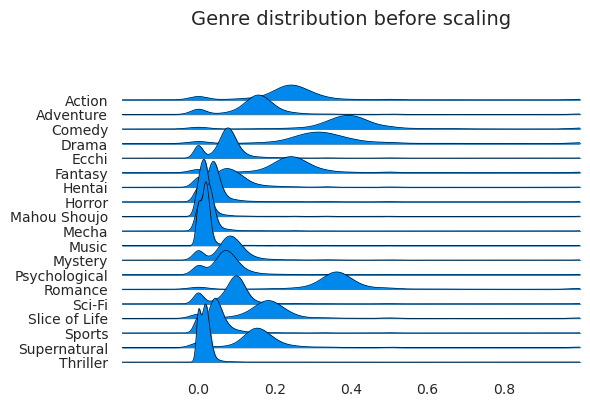

In [104]:
# # Visualize the genre distribution before scaling
# # sweetviz version
# report=sv.analyze(df_user_genre_distribution)
# report.show_notebook(w=None, h=None, scale=None, layout="vertical")

# joyplot version
df_check = df_user_genre_distribution.copy()
df_check = df_check.set_index("user_id").stack().reset_index()
df_check.columns = ["user_id", "genre", "genre_prob_scaled"]

plt.figure(figsize=(14, 14))
joyplot(
    data=df_check[["genre", "genre_prob_scaled"]],
    linewidth=0.5,
    x_range=[-0.2, 1.0],
    by="genre"
)
plt.title("Genre distribution before scaling", fontsize=14)
plt.show()

In [91]:
# Apply StandardScaler so that they're comparable across genre/tags

# get user_id column for later reference
user_ids = df_user_genre_distribution["user_id"]
# df_user_genre_distribution = df_user_genre_distribution.set_index("user_id")

# Scale data
ss = StandardScaler()
df_user_genre_distribution_val = df_user_genre_distribution.iloc[:, 1:]
df_user_genre_distribution_ss = pd.DataFrame(ss.fit_transform(df_user_genre_distribution_val), columns=df_user_genre_distribution_val.columns)
display(df_user_genre_distribution_ss)

,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,0.050389,0.219594,-0.169454,-0.303597,0.389142,0.015586,0.232277,-0.275247,0.071596,0.045606,0.393050,-0.193778,-0.300556,-0.029509,-0.075866,-0.121835,-0.139103,-0.364109,-0.278293
1,0.185118,0.137924,0.153614,-0.091043,0.047535,0.177673,-0.109194,-0.078537,-0.003788,0.061057,0.056607,-0.188448,-0.044391,0.240198,0.206074,0.292798,0.078272,-0.223076,0.116094
2,-0.023868,0.164706,-0.527193,0.003247,-0.412587,-0.501537,0.100392,-0.181152,-0.341989,0.259005,0.263466,0.145093,0.184707,-0.577338,0.405137,-0.366946,0.016499,0.165355,0.085945
3,-0.292776,0.394296,-1.264309,-0.798166,0.393244,-0.321571,2.532329,-0.641315,-0.395350,-0.484596,-0.513609,-1.043618,-0.848526,-2.446693,-1.169339,-0.672803,-0.764307,-1.385752,-0.538498
4,0.302615,0.329261,0.090129,-0.339219,0.286731,0.157433,-0.096673,0.005980,-0.134611,-0.121250,-0.133906,-0.018604,-0.058073,0.158608,0.265537,-0.018230,-0.128430,-0.102180,0.187983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6709,0.060686,0.216937,0.068066,-0.078976,0.075040,0.047682,-0.095110,-0.125576,-0.085768,0.018717,-0.006423,-0.105492,-0.144631,-0.182587,0.298716,-0.026289,0.068407,-0.224593,0.173123
6710,-0.082091,-0.499517,-0.123370,-0.457392,0.121247,-0.101474,0.179478,-0.101925,-0.013111,-0.200510,0.043030,-0.192113,-0.085965,-0.265530,0.173326,0.295284,0.156912,-0.131286,-0.282895
6711,-0.512425,-0.425729,1.169995,-0.852824,1.117926,-0.059328,0.277576,-0.016490,0.401660,-0.114378,0.066717,-0.260318,-0.147046,0.143916,-0.889379,-0.088482,-0.078292,0.482603,-0.538498
6712,-0.485140,-0.215051,0.450368,-0.500321,1.058563,-0.299243,0.220121,-0.428512,-0.395350,0.019759,0.276980,-0.154365,-0.529980,-0.191904,-0.787944,0.062923,-0.063379,0.014160,-0.084710


<Figure size 1400x1400 with 0 Axes>

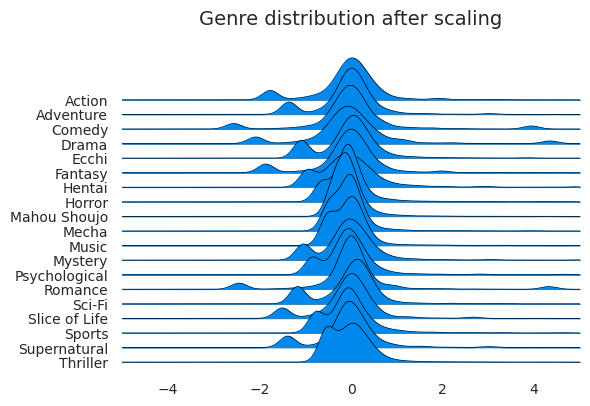

In [105]:
# Visualize the genre distribution after scaling

# # sweetviz version
# report=sv.analyze(df_user_genre_distribution_ss)
# report.show_notebook(w=None, h=None, scale=None, layout="vertical")

# joyplot version
df_user_genre_distribution_ss_viz = df_user_genre_distribution_ss.copy()
df_user_genre_distribution_ss_viz.index = user_ids
df_user_genre_distribution_ss_viz = df_user_genre_distribution_ss_viz.reset_index()
df_check = df_user_genre_distribution_ss_viz.copy()
df_check = df_check.set_index("user_id").stack().reset_index()
df_check.columns = ["user_id", "genre", "genre_prob_scaled"]

plt.figure(figsize=(14, 14))
joyplot(
    data=df_check[["genre", "genre_prob_scaled"]], 
    linewidth=0.5,
    x_range=[-5.0, 5.0],
    by="genre"
)
plt.title("Genre distribution after scaling", fontsize=14)
plt.show()

In [132]:
# Calculate user similarities: Cosine similarity
df_similarity_mat = pd.DataFrame(cosine_similarity(df_user_genre_distribution_ss))
df_similarity_mat.index = user_ids
df_similarity_mat.columns = list(user_ids)
display(df_similarity_mat)

# query a similar user
input_user_id = 1

similar_users = df_similarity_mat[input_user_id].sort_values(ascending=False).reset_index()
top_5_similar_user_ids = similar_users.iloc[:6, 0]
top_1_similar_user_id = similar_users.iloc[1, 0]
print(top_5_similar_user_ids)
print(top_1_similar_user_id)

,1,2,5,6,7,8,9,10,11,12,13,17,18,19,21,22,23,25,27,28,29,30,33,34,36,37,38,39,40,42,43,44,45,46,47,48,50,51,52,54,55,56,58,59,60,61,62,63,64,66,67,69,70,71,72,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,95,98,99,100,102,103,106,107,108,109,110,112,113,114,115,117,118,119,120,121,123,124,125,126,127,129,130,...,9690,9691,9692,9693,9695,9697,9699,9703,9704,9705,9706,9707,9708,9709,9711,9712,9715,9716,9717,9718,9720,9721,9722,9723,9724,9726,9728,9729,9732,9737,9795,9797,9845,9846,9848,9852,9854,9855,9857,9858,9859,9860,9861,9862,9863,9864,9865,9866,9867,9868,9874,9876,9878,9879,9880,9881,9882,9884,9886,9887,9888,9890,9892,9894,9895,9896,9897,9899,9900,9901,9905,9906,9907,9908,9910,9911,9913,9914,9915,9916,9917,9919,9920,9923,9925,9926,9927,9929,9930,9932,9933,9934,9936,9943,9949,9968,9971,9991,9992,10000
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.171542,-0.015214,0.558918,0.246715,0.052974,-0.513265,-0.415976,-0.427157,0.302393,0.326682,0.472750,-0.058622,-0.120508,0.021997,0.534599,0.468874,-0.114507,0.020906,0.333237,-0.539016,0.079304,0.606119,-0.086387,0.599912,-0.196161,-0.430623,0.103304,-0.025857,-0.109313,-0.266358,0.357490,-0.336603,-0.543171,0.439057,-0.303237,-0.245283,-0.363026,-0.518895,0.585769,0.399778,-0.299327,0.213591,-0.202156,0.142469,0.404985,0.387312,0.426598,-0.304242,-0.388396,0.266837,0.523113,0.392861,-0.370203,0.626929,-0.363803,0.184285,0.051438,0.046984,-0.005444,0.069562,0.314513,-0.470079,0.250566,0.689525,0.055762,-0.224297,-0.596052,0.741500,0.579360,-0.320518,0.427256,-0.118243,0.428984,-0.065396,0.630836,-0.252853,0.708857,-0.326527,-0.005408,0.625494,-0.061053,-0.133252,-0.349706,-0.365699,0.267039,-0.356833,-0.629457,-0.141443,0.295680,0.524188,0.498367,-0.082862,0.086549,0.174094,0.154569,0.249485,0.310580,0.577020,0.139706,...,0.211630,-0.242540,0.045569,0.392804,-0.347157,-0.455831,0.450579,-0.357712,-0.128689,0.401374,0.104330,0.431437,0.029484,0.549679,-0.424198,0.186579,-0.628316,-0.161408,0.260444,0.029784,0.519723,0.332114,0.524155,0.246716,0.246716,0.246716,-0.461217,-0.200186,-0.486576,0.116695,-0.390279,0.194991,0.317156,-0.359514,0.231518,0.318365,-0.157164,0.191179,-0.265753,0.509240,0.049248,-0.243537,0.397826,-0.322313,0.454462,-0.365481,0.208131,0.328565,0.243201,-0.365650,0.387828,-0.292928,-0.041569,-0.530361,-0.151277,-0.393526,-0.076503,0.681085,-0.032950,0.451732,0.052676,0.311597,0.759386,0.069110,0.337960,0.340630,-0.441737,-0.247462,0.301377,0.041039,0.025534,0.058471,0.029999,0.378975,-0.044611,-0.464328,0.568232,-0.103636,0.593916,0.349654,-0.076682,-0.367185,0.584910,-0.272619,0.202710,-0.059163,0.127773,0.523120,-0.027457,-0.211313,0.654314,0.006468,0.074765,-0.446874,0.324884,0.294301,0.304132,0.277495,0.510141,-0.397143
2,0.171542,1.000000,-0.412465,-0.333275,0.583586,0.675698,0.367133,0.292585,0.233301,0.645387,-0.254768,0.275691,-0.720127,-0.337968,0.312705,-0.183602,0.113555,0.344021,0.386908,0.358532,0.109827,0.581639,0.027691,0.341292,-0.110913,0.425419,0.395748,-0.234794,0.111186,-0.187999,0.303512,0.256205,0.261999,0.164533,-0.367525,0.513850,0.097000,0.402497,0.114092,0.437153,0.092633,0.297568,0.338536,-0.226983,0.101204,-0.339339,-0.104131,0.527346,0.341346,-0.031770,-0.006286,0.478541,0.479314,0.030227,-0.159342,-0.087042,-0.048781,0.329043,0.348320,0.234795,0.092911,-0.275577,0.356099,0.194875,-0.015538,-0.256571,0.238584,0.244584,-0.100033,-0.154010,0.617980,-0.426173,0.332402,-0.192273,0.113532,-0.233528,0.147995,0.056897,0.333432,0.472751,-0.157240,0.558514,-0.083643,0.210517,0.074974,0.040197,-0.174192,0.094479,0.209561,0.426702,0.362002,-0.111034,0.152341,0.245160,0.688904,-0.144418,0.167864,-0.326713,-0.085887,-0.638220,...,0.006253,-0.378187,0.223133,0.358224,0.474569,0.095526,-0.162129,0.102366,0.124791,0.548604,-0.036773,0.111086,0.107218,0.409098,0.351504,0

0       1
1    7828
2    6155
3    1550
4    8980
5    6830
Name: user_id, dtype: int64
7828


<Figure size 1400x1400 with 0 Axes>

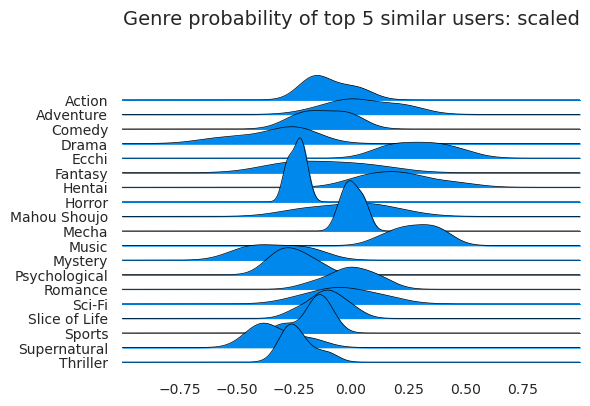

,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,0.246537,0.180055,0.368421,0.277008,0.099723,0.243767,0.102493,0.024931,0.024931,0.030471,0.033241,0.069252,0.049861,0.357341,0.083102,0.166205,0.038781,0.116343,0.008310
1198,1550,0.217391,0.156832,0.392857,0.287267,0.085404,0.232919,0.086957,0.027950,0.020186,0.027950,0.027950,0.071429,0.065217,0.374224,0.100932,0.173913,0.037267,0.128882,0.010870
4487,6155,0.238227,0.180055,0.382271,0.285319,0.091413,0.207756,0.105263,0.030471,0.008310,0.024931,0.030471,0.047091,0.044321,0.337950,0.080332,0.163435,0.041551,0.116343,0.013850
4864,6830,0.214286,0.153439,0.354497,0.232804,0.105820,0.198413,0.097884,0.029101,0.013228,0.026455,0.023810,0.047619,0.050265,0.357143,0.071429,0.169312,0.029101,0.111111,0.007937
5498,7828,0.226457,0.139013,0.365471,0.255605,0.096413,0.217489,0.121076,0.024664,0.024664,0.031390,0.026906,0.060538,0.058296,0.381166,0.087444,0.152466,0.040359,0.109865,0.008969
6263,8980,0.218605,0.158140,0.395349,0.293023,0.083721,0.260465,0.088372,0.027907,0.032558,0.027907,0.032558,0.055814,0.055814,0.362791,0.093023,0.181395,0.037209,0.139535,0.009302


<Figure size 1400x1400 with 0 Axes>

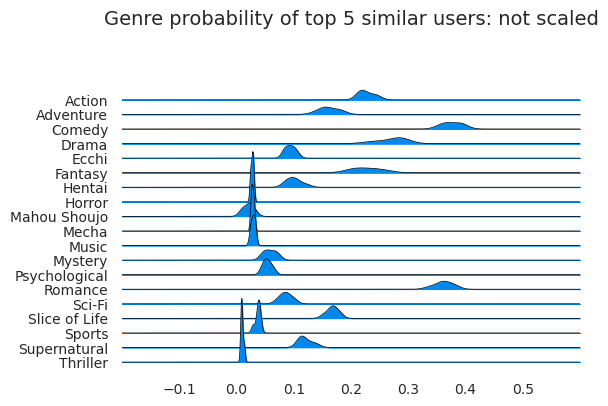

In [119]:
# Show the genre distribution of the queried user and similar users
df_check = df_user_genre_distribution_ss_viz[df_user_genre_distribution_ss_viz["user_id"].isin(top_5_similar_user_ids)]
df_check = df_check.set_index("user_id").stack().reset_index()
df_check.columns = ["user_id", "genre", "genre_prob_scaled"]

# Visualize
plt.figure(figsize=(14, 14))
joyplot(
    data=df_check[["genre", "genre_prob_scaled"]], 
    linewidth=0.5,
    x_range=[-1.0, 1.0],
    by="genre"
)
plt.title("Genre probability of top 5 similar users: scaled", fontsize=14)
plt.show()

# Similarly do it with genre probability
df_check_titles = df_user_genre_distribution[df_user_genre_distribution["user_id"].isin(top_5_similar_user_ids)]
display(df_check_titles)
df_check_titles = df_check_titles.set_index("user_id").stack().reset_index()
df_check_titles.columns = ["user_id", "genre", "genre_prob"]

# Visualize
plt.figure(figsize=(14, 14))
joyplot(
    data=df_check_titles[["genre", "genre_prob"]], 
    linewidth=0.5,
    x_range=[-0.2, 0.6],
    by="genre"
)
plt.title("Genre probability of top 5 similar users: not scaled", fontsize=14)
plt.show()

In [148]:
# get the id-romaji match for each title
id_romaji_match = df_titles[["title_id", "title_romaji"]]

# Get the titles that the queried user and the most similar user has read/watched
df_mlist = pd.read_csv("../assets/media_list_all_users.csv")
df_mlist_romaji = pd.merge(id_romaji_match, df_mlist, how="inner", on="title_id")

# Work out the overlapping and non-overlapping titles
df_sim = df_mlist_romaji[df_mlist_romaji["user_id"]==top_1_similar_user_id]
df_q = df_mlist_romaji[df_mlist_romaji["user_id"]==1]
sim_u_list = list(df_sim["title_id"])
q_u_list = list(df_q["title_id"])
overlap = list(set(sim_u_list) & set(q_u_list))
non_overlap = list(set(sim_u_list) ^ set(q_u_list))
print("for user_id: ", top_1_similar_user_id)
print("overlapping titles: ", len(overlap))
print("non-overlapping titles: ", len(non_overlap))

for user_id:  7828
overlapping titles:  152
non-overlapping titles:  734


In [184]:
# If the user is looking for something new:
# Within those "non-overlapping" titles, 
# which one matches the user genre distribution the most?

df_titles_genre = pd.read_csv("../assets/ryota_title_genre_2000p.csv")
df_non_overlap = df_titles_genre[df_titles_genre["title_id"].isin(non_overlap)]
print(len(df_non_overlap["title_id"].unique()))
print(len(df_non_overlap))

# If the user might not be looking for something new:
a = df_user_genre_distribution.loc[lambda x : x.user_id==1].iloc[:, 1:].values
b = df_non_overlap.iloc[:, 1:].values - a
display(df_user_genre_distribution.loc[lambda x : x.user_id==1])
display(df_non_overlap.iloc[:, 1:])
print(b)
print(b.shape)
b = b.sum(axis=1)
print(b.shape)

c = pd.concat([df_non_overlap["title_id"].reset_index(), pd.DataFrame(b)], axis=1)
c[0].unique()

# Choose the one that's closest to zero


734
734


,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,0.246537,0.180055,0.368421,0.277008,0.099723,0.243767,0.102493,0.024931,0.024931,0.030471,0.033241,0.069252,0.049861,0.357341,0.083102,0.166205,0.038781,0.116343,0.00831


,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
3,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0
6,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36809,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
54643,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0
72320,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
72362,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


[[ 0.7534626   0.8199446  -0.36842105 ... -0.03878116 -0.11634349
  -0.00831025]
 [ 0.7534626   0.8199446  -0.36842105 ...  0.96121884  0.88365651
  -0.00831025]
 [ 0.7534626   0.8199446   0.63157895 ... -0.03878116 -0.11634349
  -0.00831025]
 ...
 [-0.2465374  -0.1800554  -0.36842105 ... -0.03878116 -0.11634349
  -0.00831025]
 [-0.2465374  -0.1800554  -0.36842105 ... -0.03878116  0.88365651
  -0.00831025]
 [-0.2465374  -0.1800554   0.63157895 ... -0.03878116 -0.11634349
  -0.00831025]]
(734, 19)
(734,)


array([ 3.47922438,  3.47922438,  1.47922438,  1.47922438,  0.47922438,
        2.47922438,  2.47922438,  0.47922438,  0.47922438,  0.47922438,
        1.47922438,  3.47922438, -0.52077562,  0.47922438,  4.47922438,
        0.47922438,  1.47922438,  0.47922438,  0.47922438,  0.47922438,
        1.47922438, -1.52077562, -0.52077562,  1.47922438, -0.52077562,
        0.47922438, -0.52077562, -0.52077562,  0.47922438,  2.47922438,
        4.47922438, -1.52077562,  0.47922438, -1.52077562, -0.52077562])

In [158]:
# Calculate user similarities: kNN
